#Books Recommender system

We will use collaborative filtering method.

Collaborative methods for recommender systems are methods that are based solely on the past interactions recorded between users and items in order to produce new recommendations. These interactions are stored in the so-called “user-item interactions matrix”.

Dataset used: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

## Data preparation: Books

In [58]:
#libs import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [59]:
# load books df
books = pd.read_csv('Books.csv', on_bad_lines='skip')

<ipython-input-59-ff103a132f3e>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv', on_bad_lines='skip')


In [60]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [61]:
books.shape

(271360, 8)

In [62]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [63]:
# use only needed columns
books = books[books.columns[:5]]

In [64]:
books.rename(columns={"Book-Title":'title',
                      'Book-Author':'author',
                     "Year-Of-Publication":'year',
                     "Publisher":"publisher"},
             inplace=True)

In [65]:
books.isnull().sum()

,0
ISBN,0
title,0
author,2
year,0
publisher,2


In [66]:
#fill missing values
books['publisher'].fillna('Unknown', inplace=True)
books['author'].fillna('Unknown', inplace=True)

In [67]:
books.isnull().sum()

,0
ISBN,0
title,0
author,0
year,0
publisher,0


In [68]:
books['year'].describe()

,year
count,271360
unique,202
top,2002
freq,13903


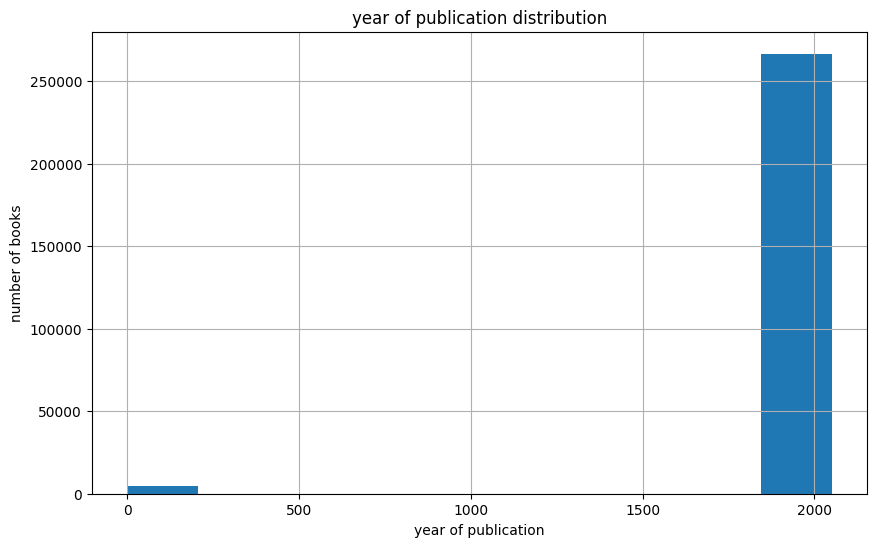

In [69]:
plt.figure(figsize=(10,6))
books['year'] = pd.to_numeric(books['year'], errors='coerce')
books['year'].hist(bins=10)
plt.title('year of publication distribution')
plt.xlabel('year of publication')
plt.ylabel('number of books')
plt.show()

In [70]:
books = books[(books['year'] <= 2024) & (books['year'] >= 1920)]
books.shape

(266683, 5)

In [71]:
books.drop_duplicates(inplace=True)
books.reset_index(drop=True, inplace=True)
books.shape

(266683, 5)

## Data preparation: Users

In [72]:
# load users df
users = pd.read_csv('Users.csv', on_bad_lines='skip')

In [73]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [74]:
users.shape

(278858, 3)

In [75]:
users.rename(columns={"User-ID":'user_id',
                      'Location':'location',
                     "Age":'age'},inplace=True)

In [76]:
users['age'].describe()

,age
count,168096.000000
mean,34.751434
std,14.428097
min,0.000000
25%,24.000000
50%,32.000000
75%,44.000000
max,244.000000


In [77]:
#users['age'] = pd.to_numeric(users['Age'], errors='coerce')
users = users[(users['age'] >= 5) & (users['age'] <= 100)]

In [78]:
#Fill NaN Values in Age Column with Median
users['age'] = users['age'].fillna(users['age'].median())

<ipython-input-78-983d88b68193>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['age'] = users['age'].fillna(users['age'].median())


In [79]:
users.describe()

,user_id,age
count,166848.000000,166848.000000
mean,139399.903889,34.746638
std,80553.359853,13.633051
min,2.000000,5.000000
25%,69919.250000,24.000000
50%,139360.000000,32.000000
75%,209153.250000,44.000000
max,278855.000000,100.000000


In [80]:
users.shape

(166848, 3)

In [81]:
users.drop_duplicates(inplace=True)
users.reset_index(drop=True, inplace=True)
users.shape

(166848, 3)

## Data preparation: Ratings

In [82]:
# load ratings df
ratings = pd.read_csv('Ratings.csv', on_bad_lines='skip')

In [83]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [84]:
ratings.shape

(1149780, 3)

In [85]:
ratings.rename(columns={"User-ID":'user_id',
                      'Book-Rating':'rating'},inplace=True)

In [86]:
ratings.describe()

,user_id,rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


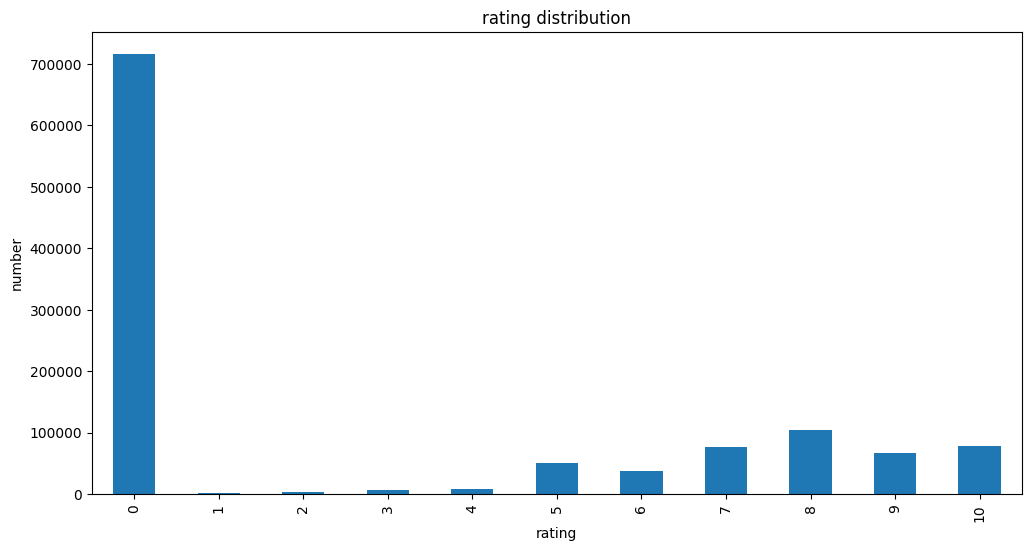

In [87]:
plt.figure(figsize=(12,6))
ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('rating distribution')
plt.xlabel('rating')
plt.ylabel('number')
plt.show()

In [88]:
ratings.drop_duplicates(inplace=True)
ratings.reset_index(drop=True, inplace=True)
ratings.shape

(1149780, 3)

## Creating matrix

In [89]:
ratings['user_id'].value_counts()

,count
user_id,
11676,13602
198711,7550
153662,6109
98391,5891
35859,5850
...,...
116180,1
116166,1
116154,1


In [90]:
# store users who had at least rated more than 200 books
x = ratings['user_id'].value_counts() > 200

In [91]:
x[x].shape

(899,)

In [92]:
y= x[x].index
ratings = ratings[ratings['user_id'].isin(y)]
ratings.head()

,user_id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [93]:
ratings.shape

(526356, 3)

In [94]:
# join ratings with books
ratings_with_books = ratings.merge(books, on='ISBN')

In [95]:
ratings_with_books.head()

,user_id,ISBN,rating,title,author,year,publisher
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc


In [96]:
ratings_with_books.shape

(482824, 7)

In [97]:
number_rating = ratings_with_books.groupby('title')['rating'].count().reset_index()
number_rating.head()

,title,rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [98]:
number_rating.rename(columns={'rating':'num_of_rating'},inplace=True)
number_rating.head()

,title,num_of_rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [99]:
final_rating = ratings_with_books.merge(number_rating, on='title')
final_rating.head()

,user_id,ISBN,rating,title,author,year,publisher,num_of_rating
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82


In [100]:
final_rating.shape

(482824, 8)

In [101]:
# take books which at least 50 ratings
final_rating = final_rating[final_rating['num_of_rating'] >= 50]
final_rating.head()

,user_id,ISBN,rating,title,author,year,publisher,num_of_rating
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82


In [102]:
final_rating.shape

(61480, 8)

In [103]:
# drop the duplicates
final_rating.drop_duplicates(['user_id','title'],inplace=True)
final_rating.shape

(59507, 8)

In [104]:
# create a pivot table
book_pivot = final_rating.pivot_table(columns='user_id', index='title', values= 'rating')
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [105]:
book_pivot.shape

(737, 888)

In [106]:
book_pivot.fillna(0, inplace=True)
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model training

In [107]:
from scipy.sparse import csr_matrix
book_sparse = csr_matrix(book_pivot)

In [108]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors= 11, algorithm="brute", metric = "cosine")

In [109]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)

In [110]:
distance, suggestion = model.kneighbors(book_pivot.iloc[237,:].values.reshape(1,-1), n_neighbors=6 )

## Generalized book recommendations


In [118]:
def get_book_recommendations(book_title, model, pivot):
    if book_title not in book_pivot.index:
        return "Book title not found."

    book_index = book_pivot.index.get_loc(book_title)
    distances, indices = model.kneighbors(pivot.iloc[book_index, :].values.reshape(1, -1), n_neighbors=11)
    recommended_books = [book_pivot.index[i] for i in indices.flatten()][1:]
    return recommended_books

In [121]:
final_rating

,user_id,ISBN,rating,title,author,year,publisher,num_of_rating
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,82
...,...,...,...,...,...,...,...,...
234557,255489,0553579983,7,And Then You Die,Iris Johansen,1998.0,Bantam,50
234558,256407,0553579983,0,And Then You Die,Iris Johansen,1998.0,Bantam,50
234559,257204,0553579983,0,And Then You Die,Iris Johansen,1998.0,Bantam,50
234560,261829,0553579983,0,And Then You Die,Iris Johansen,1998.0,Bantam,50


In [119]:
input_book = final_rating["title"].iloc[1]
print("Recommendations for book:", input_book)
recommendation = get_book_recommendations(input_book, model, book_pivot)

for i in recommendation:
    print(i)

Recommendations for book: Politically Correct Bedtime Stories: Modern Tales for Our Life and Times
Don't Stand Too Close to a Naked Man
Saving Faith
Into Thin Air : A Personal Account of the Mt. Everest Disaster
Saint Maybe
Hannibal
Blood Work
Bag of Bones
L Is for Lawless
Notes from a Small Island
The Girls' Guide to Hunting and Fishing


In [ ]:
with open('linear_model.pkl', 'wb') as f:
    pickle.dump(model, f)